# Отладка моделей

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m12sl/dl-hse-2021/blob/master/04-debug/seminar.ipynb)


План семинара:

- [ ] Освоить LR scheduling
- [ ] Написать LR range test
- [ ] Разобраться с подсчетом валидационных и тренировочных метрик 
- [ ] Добавим логгирование норм градиентов
- [ ] Посмотрим на forward-hook
- [ ] Classier Trainer

## LR Scheduling

Два типа расписаний:

- по эпохам (StepLR, ReduceLROnPlateau, ...) 
    ```
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    for epoch in range(epochs):
        train(...)
        validate(...)
        scheduler.step()
    ```


- по батчам (Cosine, Cyclic, 1cycle, ...)
    ```
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)
    for epoch in range(epochs):
        # train(...)
        for batch in data_loader:
            train_batch(...)
            scheduler.step()
        # validate(...)
    ```

## Выбор оптимального LR


Для выбора оптимального LR удобно использовать т.н. Learning Rate Range Test, часто процедуру называют просто find_lr. Под капотом проход по тренировочной эпохе с lr, изменяемым на каждом батче по формуле:

$$
\mathrm{it} = \frac{\mathrm{step}}{\mathrm{total steps}}\\
\mathrm{lr} = \exp\left\{ 
    (1 - t ) \log a + t \log b
\right\}
$$

Чтобы поменять LR для всех оптимизируемых параметров, можно пройтись по ним циклом:

```
for param_group in optimizer.param_groups:
    param_group['lr'] = lr
```


<img src="https://www.jeremyjordan.me/content/images/2018/02/lr_finder.png"/>

_картинка из бложика [Jeremy Jordan](https://www.jeremyjordan.me/nn-learning-rate/)_


Идея приема простая: пока LR меньше некоторого порога на каждом шаге градиентного спуска веса просто не меняются (в частности из-за особенностей операций с плавающей точкой).
При очень большом LR мы шагаем слишком далеко и уходим от точки экстремума. 

Оптимальный LR лежит где-то между ними. Экспоненциальная формула изменения LR позволяет с должным качеством найти хорошую точку.



Если интересно: [статья , в которой эту технику предложили и активно использовали](https://arxiv.org/pdf/1506.01186.pdf).


**Some math notes**

У типов данных с плавающей точкой есть арифметические особенности:

$$
# fp32
x + \delta == x,\,\mathrm{если}\; \delta < 5.96 \cdot 10^{-8} x
$$

К слову, это еще одна причина присматривать за величинами активаций, нормировать данные и таргет в случае регрессии. Можно было бы перейти на float64, но (вычислительно и по памяти) дешевле быть аккуратными на float32.



<img src="https://blogs.nvidia.com/wp-content/uploads/2020/05/tf32-Mantissa-chart-hi-res-FINAL-400x255.png.webp"/>

_картинка из статьи [NVIDIA](https://blogs.nvidia.com/blog/2020/05/14/tensorfloat-32-precision-format/)_

## Метрики

TL; DR:
- тренировочные метрики записывать без сглаживания с каждого батча
- валидационные собирать за всю валидацию и рисовать одной точкой


**Особенности TB**:

- При отображении прореживает точки по global_step
- Чтобы рисовать на одном графике надо писать в разные папки (завести отдельные train_ и val_writer)

## Обновим Trainer


In [36]:
from copy import deepcopy

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision.datasets import FashionMNIST
mnist = FashionMNIST("./tmp", train=True, download=True)


class VectorSet:
    def __init__(self, train=True):
        self.data = FashionMNIST("./tmp", train=train, download=True)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        img, label = self.data[item]
        img = np.array(img).astype(np.float32).reshape(-1) / 255.0
        return dict(
            sample=img,
            label=label,
        )

In [42]:
class VeryModel(nn.Module):
    def __init__(self, lr_scheduler=None, lr_scheduler_type=None):
        super().__init__()
        self.lr_scheduler = lr_scheduler
        self.lr_scheduler_type = lr_scheduler_type
        if lr_scheduler_type not in [None, 'per_batch', 'per_epoch']:
            raise ValueError("lr_scheduler_type must be one of: None, 'per_batch', 'per_epoch'. "
                             f"Not: {lr_scheduler_type}")

        self.inner = nn.Sequential(nn.Linear(784, 100),
                                   nn.ReLU(),
                                   nn.Linear(100, 10))
        
        net = resnet34(pretrained=True)
        net.fc = Linear(...)
        self.inner = net

    def forward(self, x):
        return self.inner(x)

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['sample']
        y = batch['label']
        logits = self.inner(x)
        
        F.softmax(logits).argmax() == logits.argmax()

        loss = F.cross_entropy(logits, y) # весь выч граф
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc, loss=loss.item())

        return loss, metrics

    def post_train_batch(self):
        # called after every train batch
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_batch':
            self.lr_scheduler.step()

    def post_val_batch(self):
        pass

    def post_train_stage(self):
        pass

    def post_val_stage(self, val_loss):
        # called after every end of val stage (equals to epoch end)
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_epoch':
            self.lr_scheduler.step(val_loss)


class Trainer:
    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset: Dataset,
                 tboard_log_dir: str = './tboard_logs/',
                 batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.train_writer = SummaryWriter(log_dir=tboard_log_dir + "train/")
        self.val_writer = SummaryWriter(log_dir=tboard_log_dir + "val/")
        self.cache = self.cache_states()

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf') # +inf

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                all_grads = []
                for name, p in model.named_parameters():
                    v = np.linalg.norm(p.grad.data.cpu().numpy())
                    all_grads += [v]
                    if "weight" in name:
                        self.train_writer.add_scalar(f"grad_{name}", v, global_step=self.global_step)
                        
                self.train_writer.add_scalar(f"grads", np.mean(all_grads), global_step=self.global_step)
                model.post_train_batch()
                for k, v in details.items():
                    self.train_writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1

            model.eval()
            val_losses = []
            
            val_logs = defaultdict(list)
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                val_losses.append(loss.item())
                for k, v in details.items():
                    val_logs[k].append(v)
                    
            val_logs = {k: np.mean(v) for k, v in val_logs.items()}
            for k, v in val_logs.items():
                self.val_writer.add_scalar(k, v, global_step=self.global_step)

            val_loss = np.mean(val_losses)
            model.post_val_stage(val_loss)

            if val_loss < best_loss:
                self.save_checkpoint("./best_checkpoint.pth")
                best_loss = val_loss

    def find_lr(self, min_lr: float = 1e-6,
                max_lr: float = 1e-1,
                num_lrs: int = 20,
                smooth_beta: float = 0.8) -> dict:
        # exp((1-t) * log(left) + t * log(right))
        lrs = np.geomspace(start=min_lr, stop=max_lr, num=num_lrs)
        logs = {'lr': [], 'loss': [], 'avg_loss': []}
        avg_loss = None
        model, optimizer = self.model, self.optimizer
        train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size)

        model.train()
        for lr, batch in tqdm(zip(lrs, train_loader), desc='finding LR', total=num_lrs):
            # apply new lr
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr

            # train step
            batch = {k: v.to(self.device) for k, v in batch.items()}
            loss, details = model.compute_all(batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate smoothed loss
            if avg_loss is None:
                avg_loss = loss
            else:
                avg_loss = smooth_beta * avg_loss + (1 - smooth_beta) * loss

            # store values into logs
            logs['lr'].append(lr)
            logs['avg_loss'].append(avg_loss)
            logs['loss'].append(loss)

        logs.update({key: np.array(val) for key, val in logs.items()})
        self.rollback_states()

        return logs

    def cache_states(self):
        cache_dict = {'model_state': deepcopy(self.model.state_dict()),
                      'optimizer_state': deepcopy(self.optimizer.state_dict())}

        return cache_dict

    def rollback_states(self):
        self.model.load_state_dict(self.cache['model_state'])
        self.optimizer.load_state_dict(self.cache['optimizer_state'])


In [83]:
model = VeryModel()
opt = torch.optim.SGD(model.parameters(), lr=0.2)
trainset = VectorSet(train=True)
valset = VectorSet(train=False)

trainer = Trainer(model, opt, trainset, valset, batch_size=128)
trainer.train(5)

100%|██████████| 79/79 [00:00<00:00, 85.24it/s]


In [84]:
trainer.val_writer.close()

In [74]:
len(trainset) // 128

468

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
logs = trainer.find_lr(min_lr=1e-4, max_lr=0.3, num_lrs=100)



finding LR: 100%|██████████| 100/100 [00:02<00:00, 41.31it/s]


In [78]:
trainer.

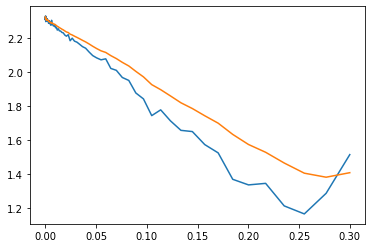

In [82]:
plt.plot(logs['lr'], logs['loss'])
plt.plot(logs['lr'], logs['avg_loss'])
# plt.plot(logs['lr'])
# plt.yscale("log")
plt.show()

In [41]:
from collections import defaultdict

# x = dict()
# x[0]


x = defaultdict(lambda: 1)
x[0]
x[1]
print(x)
# def __getitem__(self, key):
#     if key not in self.__dict__:
#         self.__dict__[key] = self.init_fn()



[{"a": 0}, {"a": 10}, {"a": 20}] -> {"a": [0, 10, 20, ...]}

defaultdict(<function <lambda> at 0x7fd6dc338a60>, {0: 1, 1: 1})


# Хуки
В случае, если нет возможности использовать интерактивную отладку или добавить print, очень удобным может оказаться добавление forward/backward хуков: функций, которые сработают при вызове forward

In [32]:
watches = {}
def hook_fn(module, inp, out):
    watches[module] = out.detach()

for name, layer in nn._modules.items():
    layer.register_forward_hook(hook_fn)

In [10]:
import torch
from torchvision.models import resnet34
import numpy as np


nn = resnet34(pretrained=True)

In [24]:
nn

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
x = torch.rand(2, 3, 224, 224)
out = nn(x)

--Return--
None
> <ipython-input-32-1b886f713a5c>(3)hook_fn()
      2 def hook_fn(module, inp, out):
----> 3     import ipdb; ipdb.set_trace()
      4 #     watches[module] = out.detach()

ipdb> print(module)
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
ipdb> print(inp)
(tensor([[[[0.6405, 0.6522, 0.6602,  ..., 0.8592, 0.0025, 0.6803],
          [0.8846, 0.1048, 0.6138,  ..., 0.5477, 0.9546, 0.5978],
          [0.1977, 0.6017, 0.6407,  ..., 0.7644, 0.8013, 0.2072],
          ...,
          [0.8693, 0.8641, 0.8068,  ..., 0.0583, 0.4243, 0.3765],
          [0.4424, 0.2710, 0.8992,  ..., 0.2351, 0.7283, 0.8143],
          [0.6501, 0.3726, 0.7520,  ..., 0.4047, 0.1835, 0.5901]],

         [[0.9451, 0.4550, 0.6606,  ..., 0.8228, 0.6265, 0.0463],
          [0.5665, 0.3650, 0.5102,  ..., 0.9672, 0.5110, 0.1856],
          [0.1578, 0.8844, 0.8374,  ..., 0.2971, 0.7097, 0.8809],
          ...,
          [0.8550, 0.8532, 0.5854,  ..., 0.6965, 0.8541, 0.9085],
    

ipdb> clear
Clear all breaks? clrscr
ipdb> clr
*** NameError: name 'clr' is not defined
ipdb> clear
Clear all breaks? y
ipdb> c
--Return--
None
> <ipython-input-32-1b886f713a5c>(3)hook_fn()
      2 def hook_fn(module, inp, out):
----> 3     import ipdb; ipdb.set_trace()
      4 #     watches[module] = out.detach()

ipdb> module
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ipdb> exit


BdbQuit: 

In [29]:
all_grads = []

for name, param in nn.named_parameters():
    x = param.data.cpu().numpy().reshape(-1)
    x = np.sqrt((x ** 2).sum())
    t = param.grad.data.cpu().numpy().reshape(-1)
    all_grads.append(t)
    t = np.sqrt((t ** 2).sum())
    print(name, x, t)


x = np.concatenate(all_grads)

conv1.weight 11.935171 1.0416042e-05
bn1.weight 2.3838437 2.4423252e-06
bn1.bias 2.7731774 5.316256e-07
layer1.0.conv1.weight 8.189711 6.8766776e-06
layer1.0.bn1.weight 2.3587146 1.140095e-06
layer1.0.bn1.bias 1.378745 9.216205e-07
layer1.0.conv2.weight 6.6911764 4.712874e-06
layer1.0.bn2.weight 2.1586852 1.2505008e-06
layer1.0.bn2.bias 1.438372 4.544441e-07
layer1.1.conv1.weight 7.1646214 3.59087e-06
layer1.1.bn1.weight 2.1580186 8.555862e-07
layer1.1.bn1.bias 1.2942387 6.894537e-07
layer1.1.conv2.weight 6.500586 3.821854e-06
layer1.1.bn2.weight 2.2491286 8.6917845e-07
layer1.1.bn2.bias 1.0933689 3.6934185e-07
layer1.2.conv1.weight 6.9216113 3.819248e-06
layer1.2.bn1.weight 2.1611712 1.0814472e-06
layer1.2.bn1.bias 1.344261 7.086904e-07
layer1.2.conv2.weight 6.1577663 3.758724e-06
layer1.2.bn2.weight 2.2449765 7.495827e-07
layer1.2.bn2.bias 0.85555875 3.0305264e-07
layer2.0.conv1.weight 9.547822 6.9345383e-06
layer2.0.bn1.weight 3.0421858 1.6717302e-06
layer2.0.bn1.bias 1.1591606 1.26

In [28]:
np.linalg.norm(x)

0.67259514